In [1]:
import pandas as pd
import catboost as cb
import plotly.express as px
from DataAnalysis import HelperFunctions as hf
from DataAnalysis import TweakedOvid
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import shap
shap.initjs()

2023-04-25 10:00:05.375033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
csdf = pd.read_csv("Dataset/changeset_data.csv")
udf = pd.read_csv("Dataset/user_data.csv")
eldf = pd.read_csv("Dataset/element_data.csv")
labels = pd.read_csv("Dataset/labels.csv")

In [23]:
#train, test = hf.split_train_test(labels, csdf=csdf, udf=udf, eldf=None, test_size=0.3, prep_data=True, to_numpy=True, one_hot=True)
#y_train, cs_train, u_train, el_train = train
#y_test, cs_test, u_test, el_test = test
#X_train = np.hstack((cs_train, u_train))
#X_test = np.hstack((cs_test, u_test))

random_state = 42
X, y = hf.get_prepped_csudf(to_numpy=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [24]:
# Following hyperparameters come from a GridSearchCV algorithm, with accuracy = 0.822
hyperparameters = {
    'hidden_layer_sizes': (1000, 1000),
    'alpha': 1e-05,
    'batch_size': 200,
    'learning_rate_init': 0.001,
    'max_iter': 400,
    'early_stopping': True,
    'validation_fraction': 0.125
}

mlp = MLPClassifier(**hyperparameters)
scaler = StandardScaler()
X_train_mlp = scaler.fit_transform(X_train)
print("pre fit")
mlp.fit(X_train_mlp, y_train)
print("post fit")

X_test_mlp = scaler.transform(X_test)
mlp_pred_test = mlp.predict(X_test_mlp)
mlp_pred_train = mlp.predict(X_train_mlp)

######################## TRAINING DATA ###########################
              precision    recall  f1-score   support

Not Reverted       0.87      0.87      0.87     21502
    Reverted       0.86      0.85      0.86     19958

    accuracy                           0.86     41460
   macro avg       0.86      0.86      0.86     41460
weighted avg       0.86      0.86      0.86     41460

########################## TEST DATA #############################
              precision    recall  f1-score   support

Not Reverted       0.83      0.83      0.83      5373
    Reverted       0.82      0.82      0.82      4992

    accuracy                           0.82     10365
   macro avg       0.82      0.82      0.82     10365
weighted avg       0.82      0.82      0.82     10365



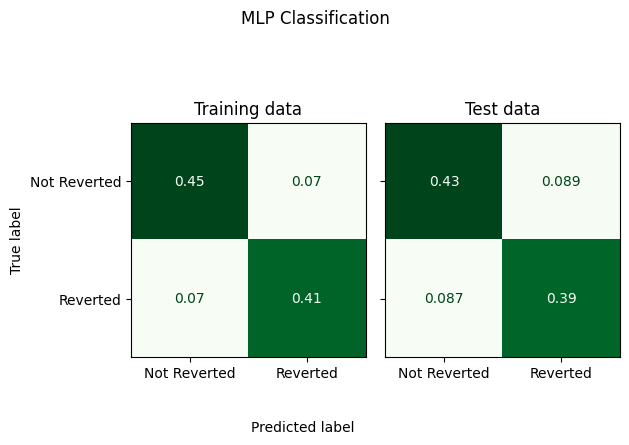

In [5]:
hf.print_report(mlp_pred_train, y_train, mlp_pred_test, y_test, title="MLP Classification")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, ax = plt.subplots(1, 1, sharey='row')
ax.set_title('Training data')
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, mlp_pred_test, normalize='all'), display_labels=['Not Reverted', 'Reverted']).plot(ax=ax, cmap='Greens')
cmd.im_.colorbar.remove()
cmd.ax_.set_xlabel('Predicted label')
cmd.ax_.set_ylabel('True label')
ax.set_title('Test data for MLP')
plt.tight_layout()
plt.show()

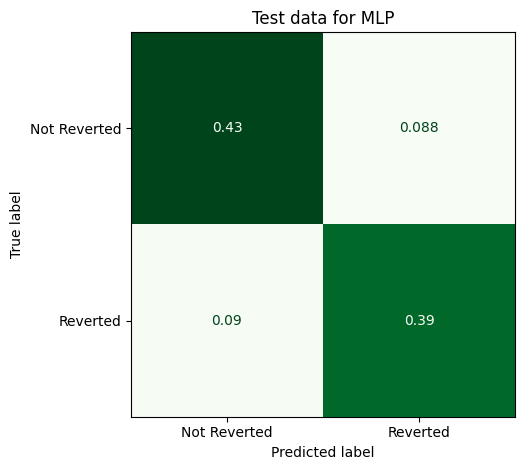

In [26]:
# explainer = shap.Explainer(mlp)
# shap_values = explainer(X_test)
#
# clust = shap.utils.hclust(X_test, y_test, linkage="single")
# shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

In [4]:
# The following hyperparameters come from a GridSearchCV.
hyperparameters = {
    'max_depth': 100,
    'max_features': 5,
    'n_estimators': 500
}
rfc = RandomForestClassifier(**hyperparameters)

rfc.fit(X_train, y_train.ravel())
rfc_pred_train = rfc.predict(X_train)
rfc_pred_test = rfc.predict(X_test)

In [9]:
hf.print_report(rfc_pred_train, y_train, rfc_pred_test, y_test, title="Random Forest Classification")

In [27]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

######################## TRAINING DATA ###########################
              precision    recall  f1-score   support

Not Reverted       1.00      1.00      1.00     21502
    Reverted       1.00      1.00      1.00     19958

    accuracy                           1.00     41460
   macro avg       1.00      1.00      1.00     41460
weighted avg       1.00      1.00      1.00     41460

########################## TEST DATA #############################
              precision    recall  f1-score   support

Not Reverted       0.87      0.89      0.88      5373
    Reverted       0.88      0.85      0.87      4992

    accuracy                           0.88     10365
   macro avg       0.88      0.87      0.87     10365
weighted avg       0.88      0.88      0.87     10365



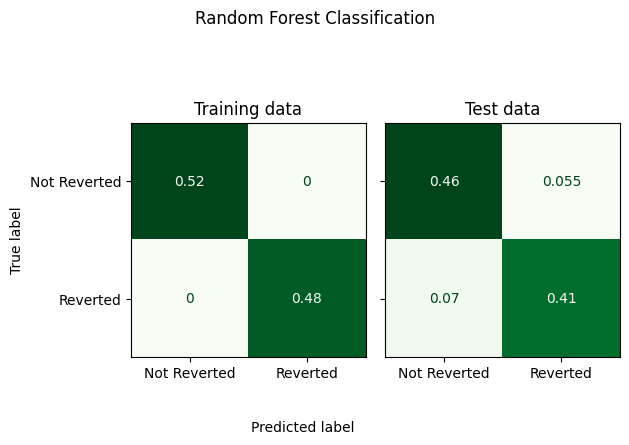

In [28]:
hf.rfc_importances(X_test, y_test, rfc, cs=True, u=True, el=False)

In [14]:
train, test, validation = hf.split_train_test_validation(labels, csdf=csdf, udf=udf, eldf=None, train_size=0.6, validation_size=0.2, test_size=0.2, prep_data=True, to_numpy=False, one_hot=False)
y_train, cs_train, u_train, el_train = train
y_test, cs_test, u_test, el_test = test
y_val, cs_val, u_val, el_val = validation
colnames = ['create_cs', 'modify_cs', 'delete_cs', 'edits', 'nnodes', 'nways', 'nrelations', 'min_lon', 'max_lon', 'min_lat', 'max_lat',
            'box_size', 'comment_len', 'imagery_used', 'editor_app', 'create_u', 'modify_u', 'delete_u', 'contributions', 'create_nodes',
            'create_ways', 'create_relations', 'nprev_changesets', 'active_weeks']
X_train = pd.concat([cs_train, u_train], axis=1)
X_train.columns = colnames
X_test = pd.concat([cs_test, u_test], axis=1)
X_test.columns = colnames
X_val = pd.concat([cs_val, u_val], axis=1)
X_val.columns = colnames

In [15]:
# detta var grid searchen som vi gjorde
param_grid = {
    'depth': [4, 7, 10],
    'l2_leaf_reg': [0.5, 3, 10],
    'learning_rate': [0.005, 0.03, 0.10]
}

# detta var hyperparametrarna som kom ut:
hyperparameters_boosted_tree = {
    'depth': 7,
    'learning_rate': 0.1,
    'l2_leaf_reg': 0.5
}

model = cb.CatBoostClassifier(iterations=12000, **hyperparameters_boosted_tree, eval_metric='Accuracy')

In [16]:
model.fit(X_train, y_train, early_stopping_rounds=1000, eval_set=[(X_val, y_val)], plot=True, cat_features=['editor_app'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7110146	test: 0.7022672	best: 0.7022672 (0)	total: 48.4ms	remaining: 9m 40s
1:	learn: 0.7409230	test: 0.7365171	best: 0.7365171 (1)	total: 76.4ms	remaining: 7m 38s
2:	learn: 0.7546229	test: 0.7524361	best: 0.7524361 (2)	total: 98.1ms	remaining: 6m 32s
3:	learn: 0.7695128	test: 0.7705740	best: 0.7705740 (3)	total: 116ms	remaining: 5m 48s
4:	learn: 0.7697701	test: 0.7669079	best: 0.7705740 (3)	total: 141ms	remaining: 5m 37s
5:	learn: 0.7853674	test: 0.7835986	best: 0.7835986 (5)	total: 163ms	remaining: 5m 26s
6:	learn: 0.7893230	test: 0.7886155	best: 0.7886155 (6)	total: 181ms	remaining: 5m 9s
7:	learn: 0.7902557	test: 0.7886155	best: 0.7886155 (6)	total: 201ms	remaining: 5m 1s
8:	learn: 0.7951439	test: 0.7925712	best: 0.7925712 (8)	total: 219ms	remaining: 4m 51s
9:	learn: 0.7942113	test: 0.7925712	best: 0.7925712 (8)	total: 236ms	remaining: 4m 43s
10:	learn: 0.7969448	test: 0.7945007	best: 0.7945007 (10)	total: 256ms	remaining: 4m 39s
11:	learn: 0.8000000	test: 0.7989387	bes

In [17]:
cb_pred_train = model.predict(X_train)
cb_pred_test = model.predict(X_test)

######################## TRAINING DATA ###########################
              precision    recall  f1-score   support

Not Reverted       1.00      1.00      1.00     16182
    Reverted       1.00      1.00      1.00     14913

    accuracy                           1.00     31095
   macro avg       1.00      1.00      1.00     31095
weighted avg       1.00      1.00      1.00     31095

########################## TEST DATA #############################
              precision    recall  f1-score   support

Not Reverted       0.89      0.89      0.89      5404
    Reverted       0.88      0.88      0.88      4961

    accuracy                           0.88     10365
   macro avg       0.88      0.88      0.88     10365
weighted avg       0.88      0.88      0.88     10365



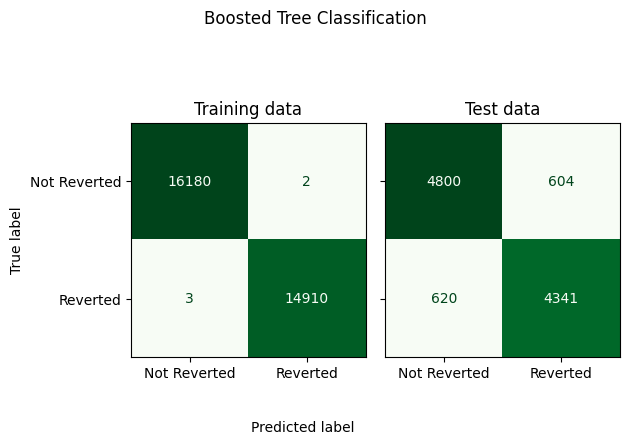

In [20]:
hf.print_report(cb_pred_train, y_train, cb_pred_test, y_test, title="Boosted Tree Classification", normalize=False)

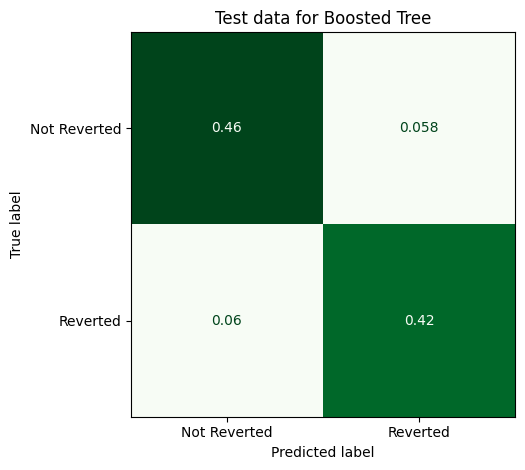

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, ax = plt.subplots(1, 1, sharey='row')
ax.set_title('Training data')
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, cb_pred_test, normalize='all'), display_labels=['Not Reverted', 'Reverted']).plot(ax=ax, cmap='Greens')
cmd.im_.colorbar.remove()
cmd.ax_.set_xlabel('Predicted label')
cmd.ax_.set_ylabel('True label')
ax.set_title('Test data for Boosted Tree')
plt.tight_layout()
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


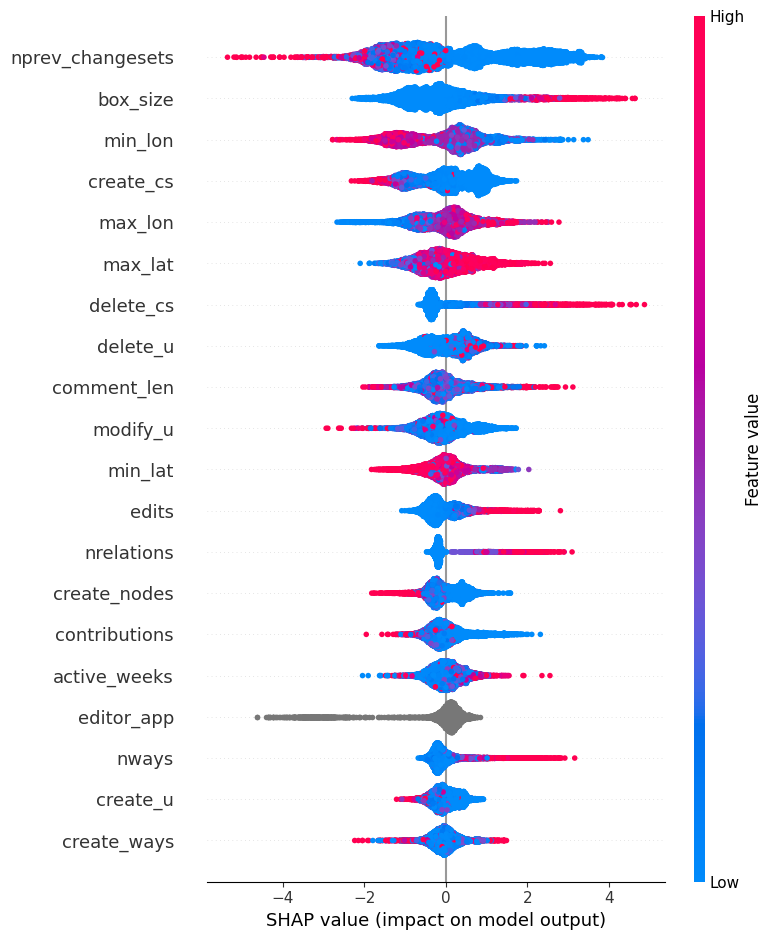

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

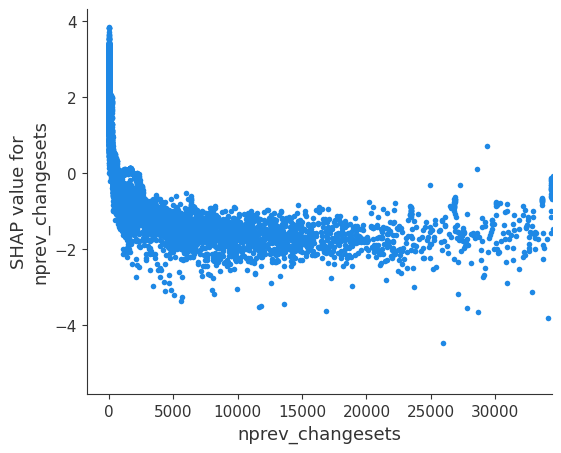

In [17]:
shap.dependence_plot('nprev_changesets', shap_values, X_test, xmin="percentile(0.0)", xmax="percentile(95)", x_jitter=0.5, interaction_index=None)

324/324 [==============================] - 1s 2ms/step
######################## TRAINING DATA ###########################
              precision    recall  f1-score   support

Not Reverted       0.81      0.83      0.82     18843
    Reverted       0.81      0.79      0.80     17434

    accuracy                           0.81     36277
   macro avg       0.81      0.81      0.81     36277
weighted avg       0.81      0.81      0.81     36277

########################## TEST DATA #############################
              precision    recall  f1-score   support

Not Reverted       0.80      0.82      0.81      5373
    Reverted       0.80      0.78      0.79      4992

    accuracy                           0.80     10365
   macro avg       0.80      0.80      0.80     10365
weighted avg       0.80      0.80      0.80     10365



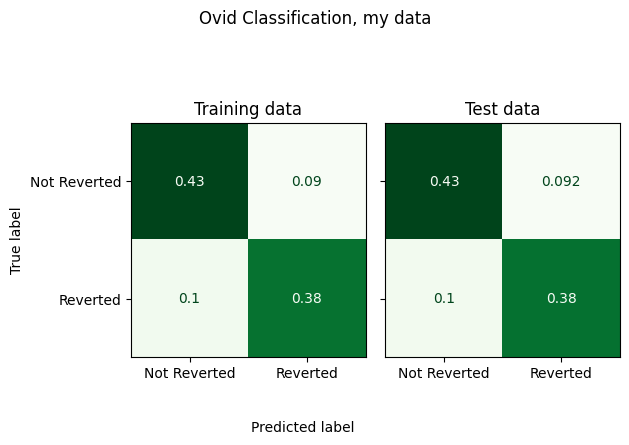

In [11]:
original_data = True
my_data = False

# the original model was trained with random_state = 42, so the same will be used below for reproducibility
random_state = 42

no_changeset_features = 20 if original_data else 21
ovid = TweakedOvid.Ovid(no_changeset_features=no_changeset_features)

features_df = pd.read_csv('/Users/dansvenonius/PycharmProjects/MastersThesis/Dataset/ovid_data.csv').set_index("cs_id")
if original_data:
    ovid.load("/Users/dansvenonius/PycharmProjects/MastersThesis/models/ovid_model_original_data")
    features_df.drop(labels=['nprev_changesets', 'imagery_used'], inplace=True, axis='columns')
    title = "Ovid Classification, original data"
elif my_data:
    ovid.load("/Users/dansvenonius/PycharmProjects/MastersThesis/models/ovid_model_my_data")
    features_df.drop(labels='acc_created', inplace=True, axis='columns')
    title = "Ovid Classification, my data"

labels_features = labels.set_index("cs_id").join(features_df, how="left").reset_index()
labels_features.fillna(0, inplace=True)

y_ovid = labels_features["label"].to_numpy()
X_ovid = labels_features.drop(["label", "cs_id"], axis='columns').to_numpy()

# 20% test
X_train_ovid, X_test_ovid, y_train_ovid, y_test_ovid = train_test_split(X_ovid, y_ovid, test_size=0.2, random_state=random_state)

# 10% validation, 70% train
X_train_ovid, X_val_ovid, y_train_ovid, y_val_ovid = train_test_split(X_train_ovid, y_train_ovid, test_size=0.125, random_state=random_state)
ovid.fit_scaler(X_train_ovid)

ovid_pred_train = ovid.predict(X_train_ovid)
ovid_pred_test = ovid.predict(X_test_ovid)

hf.print_report(ovid_pred_train, y_train_ovid, ovid_pred_test, y_test_ovid, title=title)

In [3]:
hf.tSNEplot(labels, csdf=csdf, udf=udf)

324/324 [==============================] - 1s 3ms/step


In [2]:
# INTRODUCING A THREE CLASSES: FULLY/PARTIALLY/NOT REVERTED
random_state = 42
multi_file = 'multi_labels_part.csv'
target_names = ['full', 'partial', 'non']
path = 'Dataset/'

######################## TRAINING DATA ###########################
              precision    recall  f1-score   support

        full       1.00      1.00      1.00     18374
     partial       1.00      1.00      1.00      1584
         non       1.00      1.00      1.00     21502

    accuracy                           1.00     41460
   macro avg       1.00      1.00      1.00     41460
weighted avg       1.00      1.00      1.00     41460

########################## TEST DATA #############################
              precision    recall  f1-score   support

        full       0.85      0.84      0.84      4600
     partial       0.84      0.21      0.34       392
         non       0.86      0.91      0.88      5373

    accuracy                           0.85     10365
   macro avg       0.85      0.66      0.69     10365
weighted avg       0.85      0.85      0.85     10365



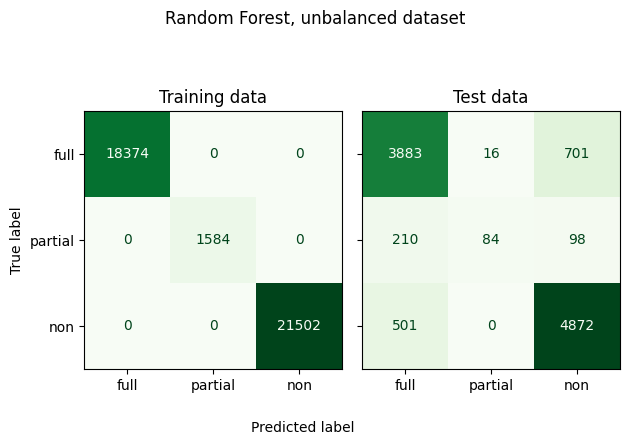

In [3]:
X, y = hf.get_prepped_csudf(path, multi_label=True, multi_file=multi_file, to_numpy=False)
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy().argmax(axis=1), test_size=0.2, random_state=random_state)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_train, pred_test = rfc.predict(X_train), rfc.predict(X_test)
hf.print_report(pred_train, y_train, pred_test, y_test, target_names, title="Random Forest, unbalanced dataset", normalize=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.047993
0:	learn: 0.6726399	test: 0.6777476	best: 0.6777476 (0)	total: 11.3ms	remaining: 1m 52s
1:	learn: 0.6940088	test: 0.6977205	best: 0.6977205 (1)	total: 18.6ms	remaining: 1m 32s
2:	learn: 0.7099680	test: 0.7126608	best: 0.7126608 (2)	total: 26.6ms	remaining: 1m 28s
3:	learn: 0.6940415	test: 0.6962368	best: 0.7126608 (2)	total: 34.4ms	remaining: 1m 25s
4:	learn: 0.7128198	test: 0.7132929	best: 0.7132929 (4)	total: 41.6ms	remaining: 1m 23s
5:	learn: 0.7116035	test: 0.7122654	best: 0.7132929 (4)	total: 50.1ms	remaining: 1m 23s
6:	learn: 0.7149425	test: 0.7156442	best: 0.7156442 (6)	total: 57.3ms	remaining: 1m 21s
7:	learn: 0.7167579	test: 0.7171081	best: 0.7171081 (7)	total: 64.3ms	remaining: 1m 20s
8:	learn: 0.7150934	test: 0.7149866	best: 0.7171081 (7)	total: 71.4ms	remaining: 1m 19s
9:	learn: 0.7220549	test: 0.7244555	best: 0.7244555 (9)	total: 78.6ms	remaining: 1m 18s
10:	learn: 0.7348008	test: 0.7376006	best: 0.7376006 (10)	total: 87.2ms	remaining: 1m 19s


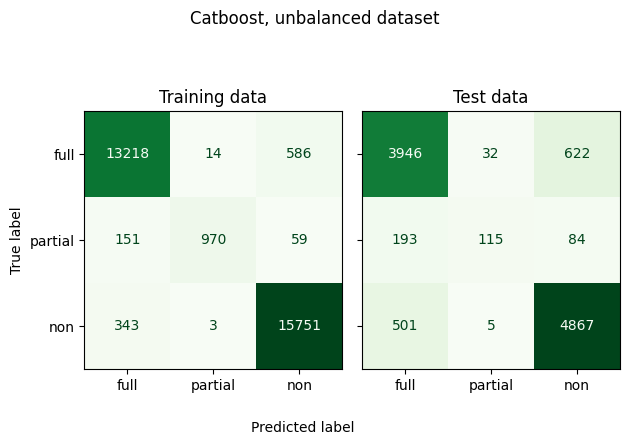

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)
cb_model = CatBoostClassifier(iterations=10000, eval_metric='TotalF1')
cb_model.fit(X_train, y_train, early_stopping_rounds=1500, eval_set=[(X_val, y_val)], plot=True)
pred_train, pred_test = cb_model.predict(X_train), cb_model.predict(X_test)
hf.print_report(pred_train, y_train, pred_test, y_test, target_names, title="Catboost, unbalanced dataset", normalize=False)

######################## TRAINING DATA ###########################
              precision    recall  f1-score   support

        full       1.00      1.00      1.00      1557
     partial       1.00      1.00      1.00      1613
         non       1.00      1.00      1.00      1572

    accuracy                           1.00      4742
   macro avg       1.00      1.00      1.00      4742
weighted avg       1.00      1.00      1.00      4742

########################## TEST DATA #############################
              precision    recall  f1-score   support

        full       0.75      0.61      0.67       419
     partial       0.63      0.75      0.69       363
         non       0.75      0.76      0.76       404

    accuracy                           0.71      1186
   macro avg       0.71      0.71      0.70      1186
weighted avg       0.71      0.71      0.70      1186



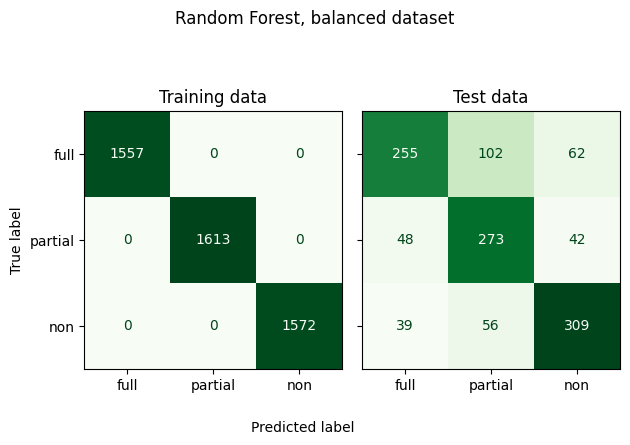

In [9]:
n_samples = np.where(y['partial_revert'] == True, 1, 0).sum()
X_full = X.loc[y['full_revert'], :].sample(n_samples)
X_non = X.loc[y['not_revert'], :].sample(n_samples)
X_rev = X.loc[y['partial_revert'], :].sample(n_samples)

X = pd.concat([X_full, X_rev, X_non]).join(y)
y = X.loc[:, ['full_revert', 'partial_revert', 'not_revert']].to_numpy().argmax(axis=1)
X = X.drop(labels=['full_revert', 'partial_revert', 'not_revert'], axis=1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_train, pred_test = rfc.predict(X_train), rfc.predict(X_test)
hf.print_report(pred_train, y_train, pred_test, y_test, target_names, title="Random Forest, balanced dataset", normalize=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.045957
0:	learn: 0.5784100	test: 0.5697061	best: 0.5697061 (0)	total: 4.39ms	remaining: 43.9s
1:	learn: 0.5893360	test: 0.5754830	best: 0.5754830 (1)	total: 9.33ms	remaining: 46.7s
2:	learn: 0.5970383	test: 0.5737072	best: 0.5754830 (1)	total: 13.8ms	remaining: 46s
3:	learn: 0.6088047	test: 0.5815248	best: 0.5815248 (3)	total: 17.6ms	remaining: 43.9s
4:	learn: 0.6166872	test: 0.5864679	best: 0.5864679 (4)	total: 21.7ms	remaining: 43.3s
5:	learn: 0.6158601	test: 0.5888916	best: 0.5888916 (5)	total: 26.9ms	remaining: 44.8s
6:	learn: 0.6207791	test: 0.6008918	best: 0.6008918 (6)	total: 30.4ms	remaining: 43.4s
7:	learn: 0.6234900	test: 0.6047711	best: 0.6047711 (7)	total: 33.9ms	remaining: 42.3s
8:	learn: 0.6230552	test: 0.6027397	best: 0.6047711 (7)	total: 37.3ms	remaining: 41.4s
9:	learn: 0.6260030	test: 0.6037930	best: 0.6047711 (7)	total: 41.1ms	remaining: 41s
10:	learn: 0.6248057	test: 0.6018182	best: 0.6047711 (7)	total: 44.7ms	remaining: 40.6s
11:	learn: 0.626

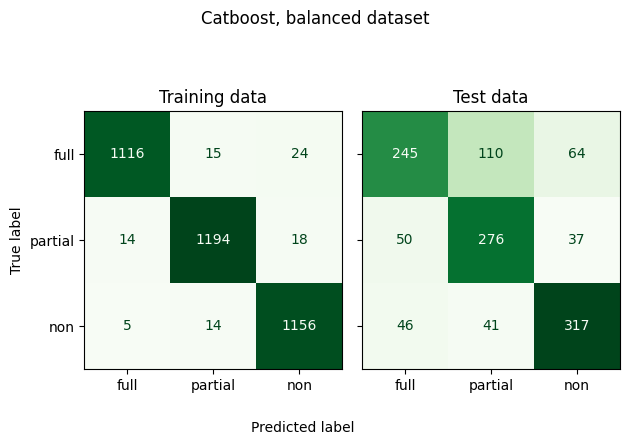

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)
cb_model = CatBoostClassifier(iterations=10000, eval_metric='TotalF1')
cb_model.fit(X_train, y_train, early_stopping_rounds=1500, eval_set=[(X_val, y_val)], plot=True)
pred_train, pred_test = cb_model.predict(X_train), cb_model.predict(X_test)
hf.print_report(pred_train, y_train, pred_test, y_test, target_names, title="Catboost, balanced dataset", normalize=False)

######################## TRAINING DATA ###########################
                precision    recall  f1-score   support

    not_revert       1.00      1.00      1.00      1579
partial_revert       1.00      1.00      1.00      1582

      accuracy                           1.00      3161
     macro avg       1.00      1.00      1.00      3161
  weighted avg       1.00      1.00      1.00      3161

########################## TEST DATA #############################
                precision    recall  f1-score   support

    not_revert       0.85      0.88      0.86       397
partial_revert       0.87      0.84      0.86       394

      accuracy                           0.86       791
     macro avg       0.86      0.86      0.86       791
  weighted avg       0.86      0.86      0.86       791



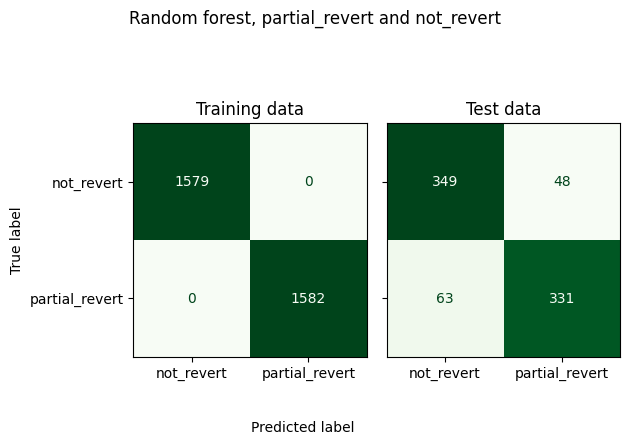

In [8]:
c1, c2 = 'partial_revert', 'not_revert' # possible values: 'partial_revert', 'full_revert', 'not_revert'
X, y = hf.get_2_of_3_classes(path, 'partial_revert', 'not_revert', multi_file, to_numpy=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_train, pred_test = rfc.predict(X_train), rfc.predict(X_test)
hf.print_report(pred_train, y_train, pred_test, y_test, [c2, c1], title=f'Random forest, {c1} and {c2}', normalize=False)

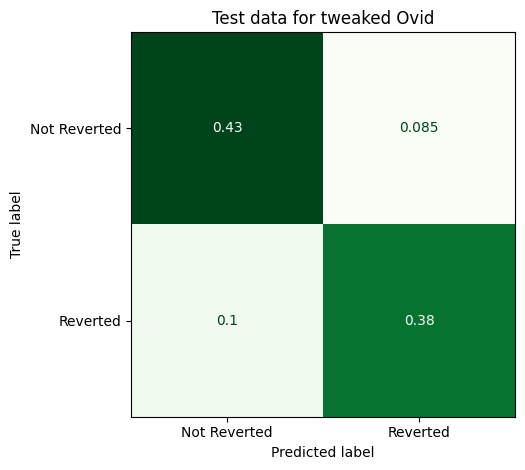

In [ ]:
# px.histogram(plot_csdf, x='create', log_y=True, color="split", barmode="overlay", histnorm="percent",
#              nbins=50, title="Changeset Data", width=600)